In [18]:
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

from lstm.lstmmodel import LSTM
from lstm.lstmmodel import LSTMDS
from vae.vaemodel import VAE

In [3]:
data = np.load("lstm/data.npz")
data = [data["obs"], data["act"], data["rew"], data["nex"]]

In [4]:
with open("config.json", "r") as f:
    config = json.load(f)
vae = VAE(config["img_size"], config["latent_dim"], config["encoder_blocks"], config["decoder_blocks"])
vae.load_state_dict(torch.load("lstm/vae.pt", weights_only=True))
vae.eval()

<All keys matched successfully>

In [5]:
lstm = LSTM(32, 1, 64)
lstm.load_state_dict(torch.load("lstm/lstm.pt", weights_only=True))
lstm.eval()

<All keys matched successfully>

In [8]:
train_ds = LSTMDS(data, vae)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=False)

VAE data shape:  torch.Size([80000, 3, 96, 96])
VAE data shape:  torch.Size([80000, 3, 96, 96])
LSTM Data shape
torch.Size([160, 500, 32]) torch.Size([160, 500, 1]) torch.Size([160, 500, 1]) torch.Size([160, 500, 32])


In [15]:
device = "mps"
lstm.to(device)
rollouts = []
with torch.no_grad():
    for z, a, r, next_z in train_dl:
        z = z.to(device)
        a = a.to(device)
        r = r.to(device)
        next_z = next_z.to(device)

        h0 = torch.zeros(1, z.shape[0], 64).detach().clone().to(device)
        c0 = torch.zeros(1, z.shape[0], 64).detach().clone().to(device)
        zt, rt, ht, ct = lstm(z, a, h0, c0)

        for i in range(z.shape[0]):
            rollouts.append((z[i].cpu(), zt[i].cpu(), next_z[i].cpu()))

In [44]:
def visualize_frame(data, rollouts, roll, frame):
    with torch.no_grad():
        obs = data[0][roll][frame]
        next_obs = data[3][roll][frame]

        # rollouts: (N, 3, L, D)
        rollout = rollouts[roll]
        # (L, D)
        z, next_z, zt = rollout

        # (D)
        z_f = z[frame]
        next_z_f = next_z[frame]
        zt_f = zt[frame]

        vae.to("cpu")

        z_decoded = vae.decode(z_f.unsqueeze(0))
        next_z_decoded = vae.decode(next_z_f.unsqueeze(0))
        zt_decoded = vae.decode(zt_f.unsqueeze(0))

        z_transformed = z_decoded.squeeze().permute(1, 2, 0).numpy()
        next_z_transformed = next_z_decoded.squeeze().permute(1, 2, 0).numpy()
        zt_transformed = zt_decoded.squeeze().permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    axs[0].set_title(f"Real frame {frame}")
    axs[0].imshow(obs)
    axs[0].axis("off")

    axs[1].set_title(f"Real frame {frame+1}")
    axs[1].imshow(next_obs)
    axs[1].axis("off")

    axs[2].set_title(f"Z Frame {frame}")
    axs[2].imshow(z_transformed)
    axs[2].axis("off")

    axs[3].set_title(f"True z frame {frame+1}")
    axs[3].imshow(next_z_transformed)
    axs[3].axis("off")

    axs[4].set_title(f"Predicted z frame {frame+1}")
    axs[4].imshow(zt_transformed)
    axs[4].axis("off")

    plt.show()

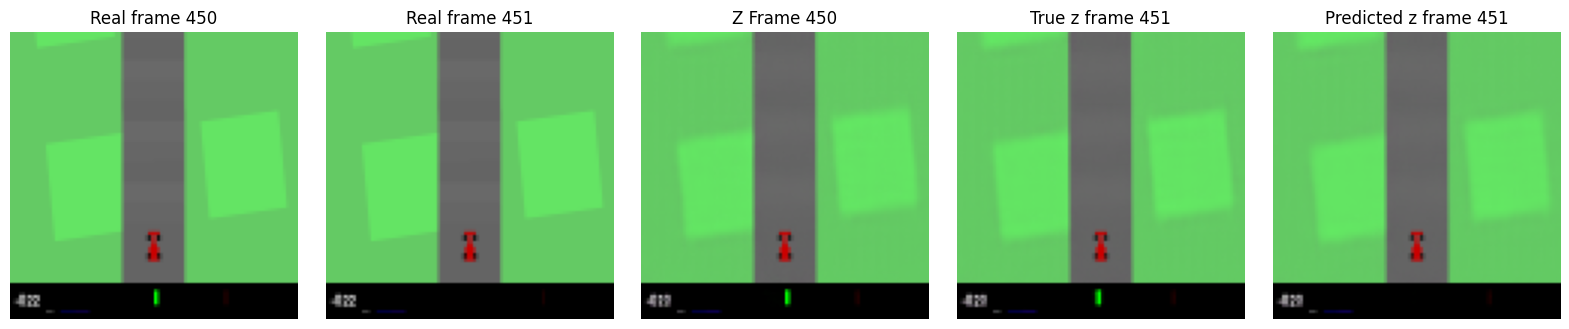

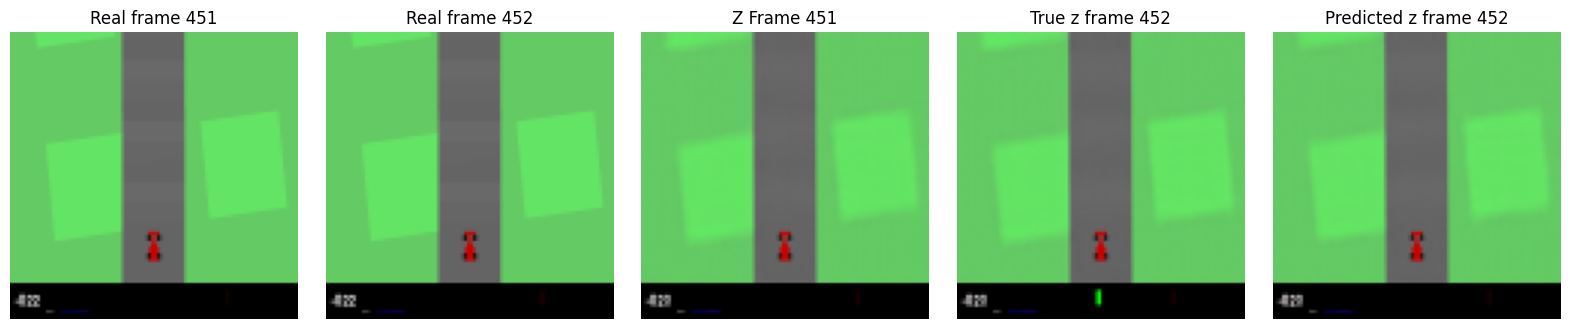

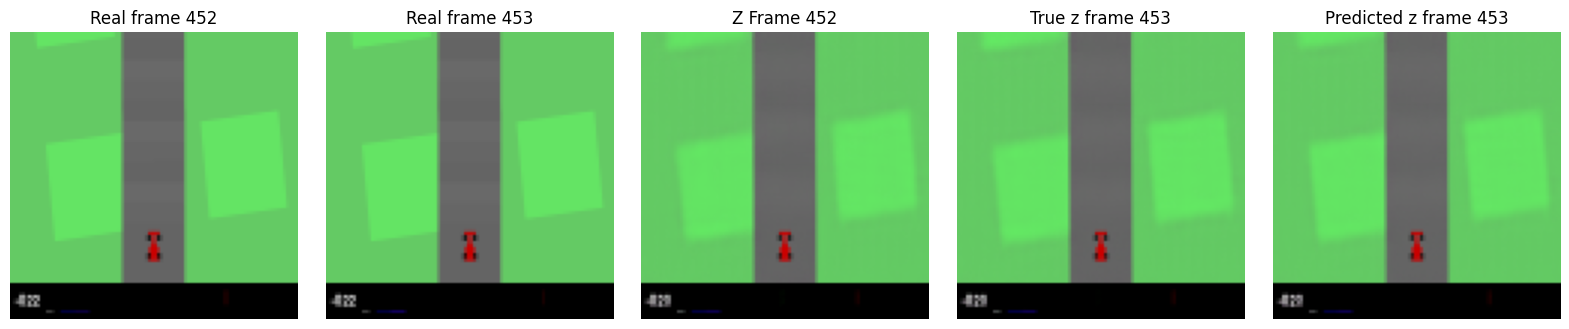

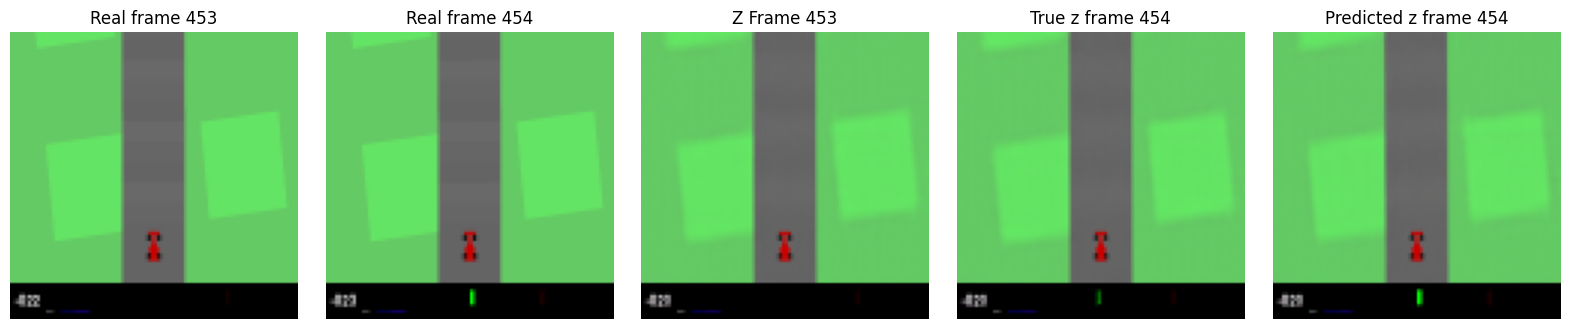

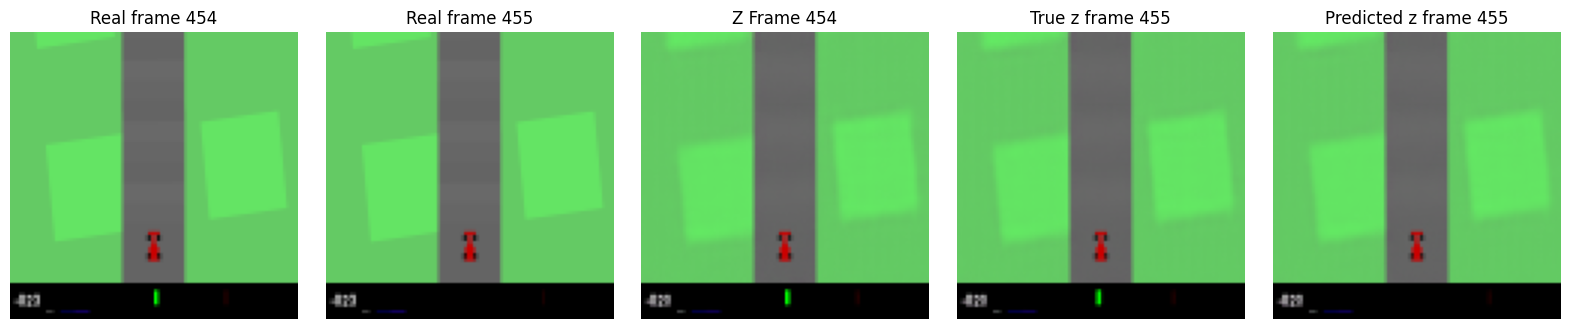

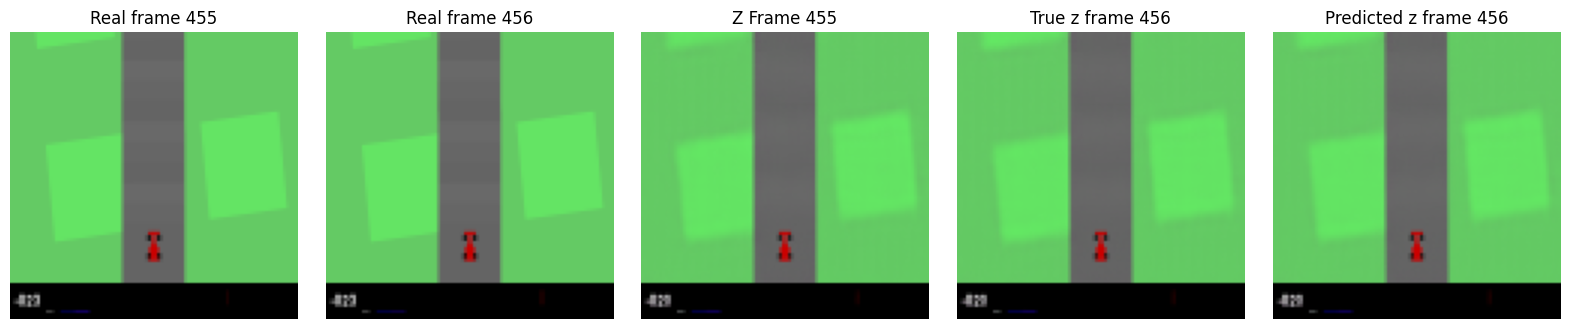

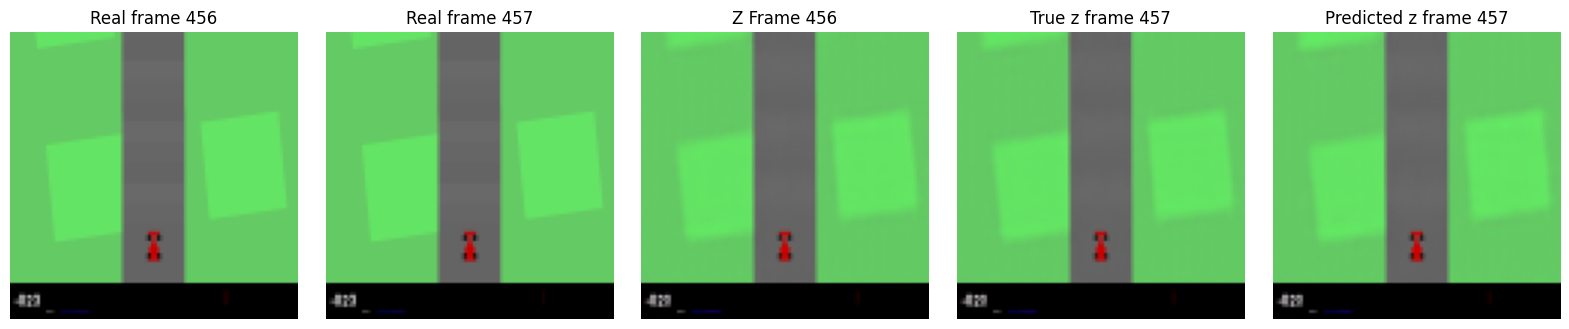

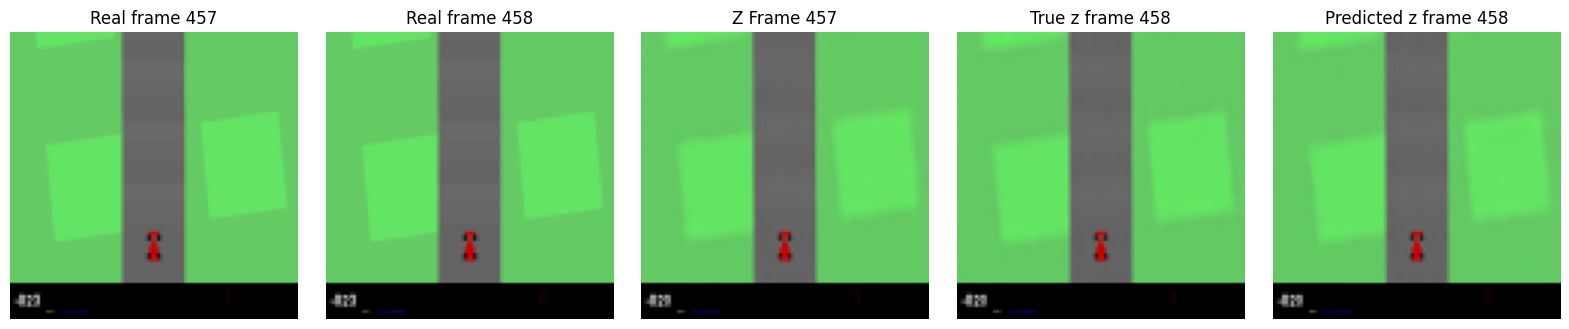

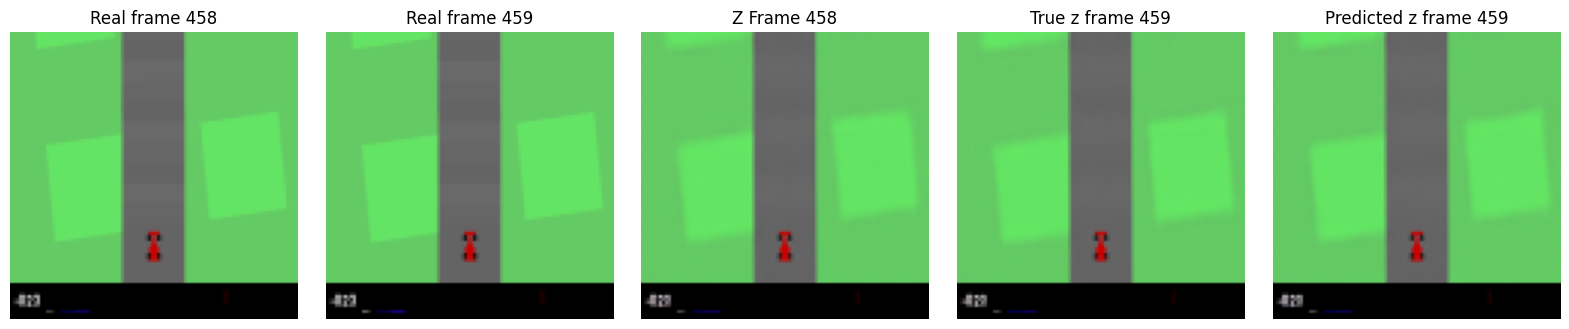

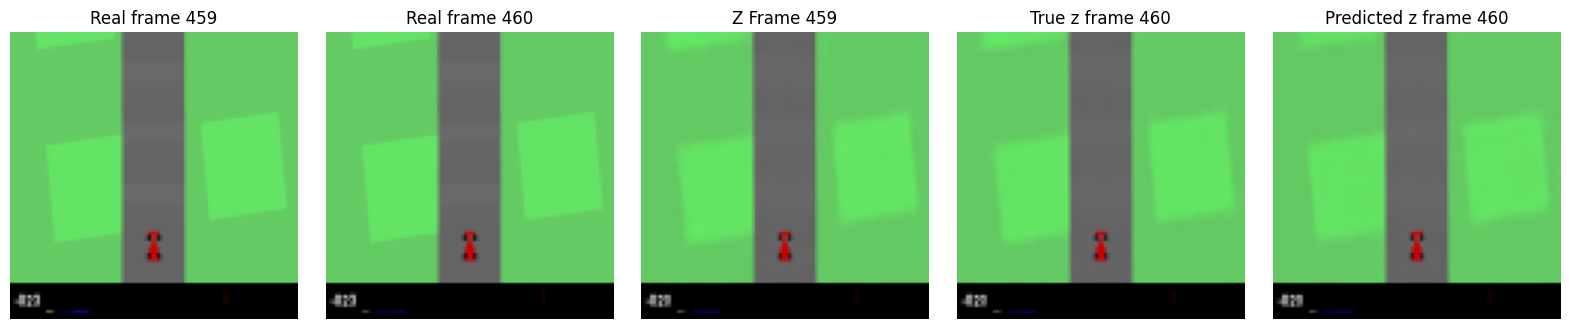

In [55]:
for frame in range(0, 10):
    visualize_frame(data, rollouts, 0, frame)